

---

<center><h1>Assignment 4</h1></center>

---

# 1. <font color='#556b2f'> **Support Vector Machines with Synthetic Data**</font>, 50 points. 

For this problem, we will generate synthetic data for a nonlinear binary classification problem and partition it into training, validation and test sets. Our goal is to understand the behavior of SVMs with Radial-Basis Function (RBF) kernels with different values of $C$ and $\gamma$.

In [0]:
# DO NOT EDIT THIS FUNCTION; IF YOU WANT TO PLAY AROUND WITH DATA GENERATION, 
# MAKE A COPY OF THIS FUNCTION AND THEN EDIT
#
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def generate_data(n_samples, tst_frac=0.2, val_frac=0.2):
  # Generate a non-linear data set
  X, y = make_moons(n_samples=n_samples, noise=0.25, random_state=42)
   
  # Take a small subset of the data and make it VERY noisy; that is, generate outliers
  m = 30
  np.random.seed(30)  # Deliberately use a different seed
  ind = np.random.permutation(n_samples)[:m]
  X[ind, :] += np.random.multivariate_normal([0, 0], np.eye(2), (m, ))
  y[ind] = 1 - y[ind]

  # Plot this data
  cmap = ListedColormap(['#b30065', '#178000'])  
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k')       
  
  # First, we use train_test_split to partition (X, y) into training and test sets
  X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=tst_frac, 
                                                random_state=42)

  # Next, we use train_test_split to further partition (X_trn, y_trn) into training and validation sets
  X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size=val_frac, 
                                                random_state=42)
  
  return (X_trn, y_trn), (X_val, y_val), (X_tst, y_tst)

In [0]:
#
#  DO NOT EDIT THIS FUNCTION; IF YOU WANT TO PLAY AROUND WITH VISUALIZATION, 
#  MAKE A COPY OF THIS FUNCTION AND THEN EDIT 
#

def visualize(models, param, X, y):
  # Initialize plotting
  if len(models) % 3 == 0:
    nrows = len(models) // 3
  else:
    nrows = len(models) // 3 + 1
    
  fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 5.0 * nrows))
  cmap = ListedColormap(['#b30065', '#178000'])

  # Create a mesh
  xMin, xMax = X[:, 0].min() - 1, X[:, 0].max() + 1
  yMin, yMax = X[:, 1].min() - 1, X[:, 1].max() + 1
  xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.01), 
                             np.arange(yMin, yMax, 0.01))

  for i, (p, clf) in enumerate(models.items()):
    # if i > 0:
    #   break
    r, c = np.divmod(i, 3)
    ax = axes[r, c]

    # Plot contours
    zMesh = clf.decision_function(np.c_[xMesh.ravel(), yMesh.ravel()])
    zMesh = zMesh.reshape(xMesh.shape)
    ax.contourf(xMesh, yMesh, zMesh, cmap=plt.cm.PiYG, alpha=0.6)

    if (param == 'C' and p > 0.0) or (param == 'gamma'):
      ax.contour(xMesh, yMesh, zMesh, colors='k', levels=[-1, 0, 1], 
                 alpha=0.5, linestyles=['--', '-', '--'])

    # Plot data
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k')       
    ax.set_title('{0} = {1}'.format(param, p))

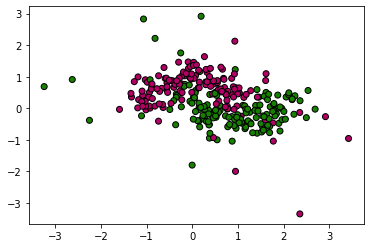

In [3]:
# Generate the data
n_samples = 300    # Total size of data set 
(X_trn, y_trn), (X_val, y_val), (X_tst, y_tst) = generate_data(n_samples)

---
### **a**. (25 points)  The effect of the regularization parameter, $C$
Complete the Python code snippet below that takes the generated synthetic 2-d data as input and learns non-linear SVMs. Use scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function to learn SVM models with **radial-basis kernels** for fixed $\gamma$ and various choices of $C \in \{10^{-3}, 10^{-2}\, \cdots, 1, \, \cdots\, 10^5\}$. The value of $\gamma$ is fixed to $\gamma = \frac{1}{d \cdot \sigma_X}$, where $d$ is the data dimension and $\sigma_X$ is the standard deviation of the data set $X$. SVC can automatically use these setting for $\gamma$ if you pass the argument gamma = 'scale' (see documentation for more details).

**Plot**: For each classifier, compute **both** the **training error** and the **validation error**. Plot them together, making sure to label the axes and each curve clearly.

**Discussion**: How do the training error and the validation error change with $C$? Based on the visualization of the models and their resulting classifiers, how does changing $C$ change the models? Explain in terms of minimizing the SVM's objective function $\frac{1}{2} \mathbf{w}^\prime \mathbf{w} \, + \, C \, \Sigma_{i=1}^n \, \ell(\mathbf{w} \mid \mathbf{x}_i, y_i)$, where $\ell$ is the hinge loss for each training example $(\mathbf{x}_i, y_i)$.

**Final Model Selection**: Use the validation set to select the best the classifier corresponding to the best value, $C_{best}$. Report the accuracy on the **test set** for this selected best SVM model. _Note: You should report a single number, your final test set accuracy on the model corresponding to $C_{best}$_.

0.001 0.5416666666666667
0.01 0.5416666666666667
0.1 0.20833333333333337
1.0 0.125
10.0 0.10416666666666663
100.0 0.14583333333333337
1000.0 0.10416666666666663
10000.0 0.1875
100000.0 0.20833333333333337
Best value of C: 10.0
Accuracy of test data as per best C: 0.21666666666666667


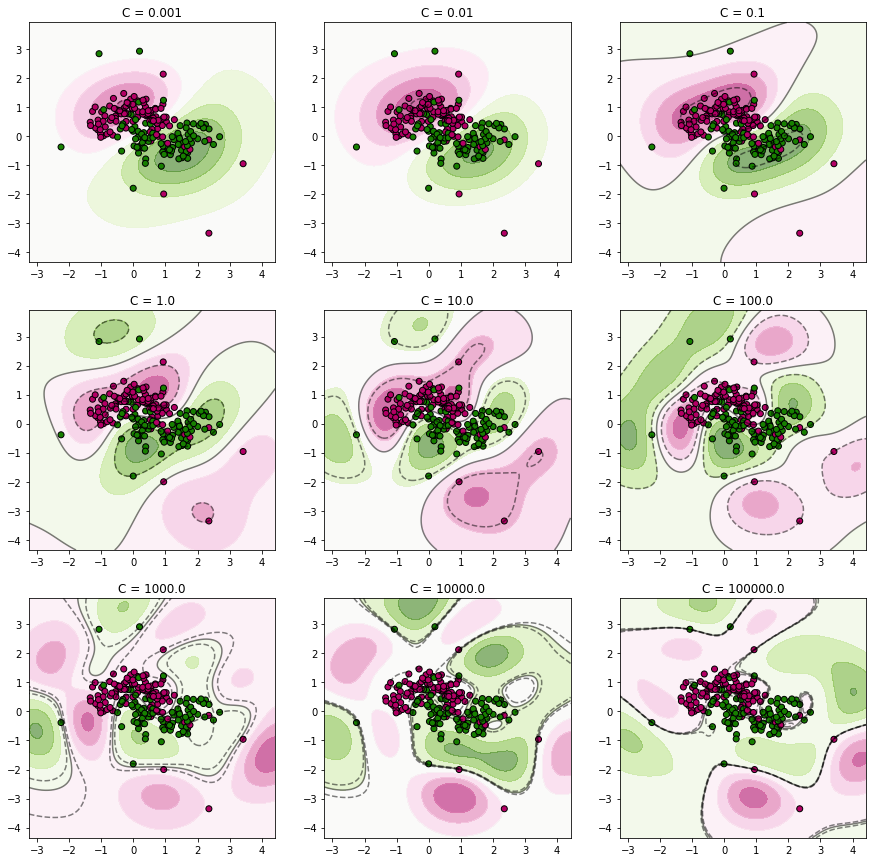

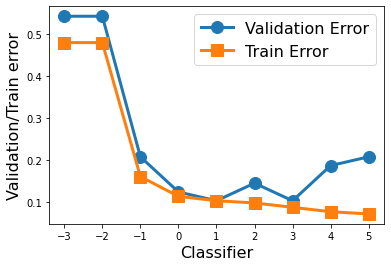

In [4]:
# Learn support vector classifiers with a radial-basis function kernel with 
# fixed gamma = 1 / (n_features * X.std()) and different values of C
import math
from sklearn.svm import SVC
C_range = np.arange(-3.0, 6.0, 1.0)
C_values = np.power(10.0, C_range)

models = dict()
trnErr = dict()
valErr = dict()
maxim=math.inf
for C in C_values:
 
  # Insert your code here to learn SVM models
 clf = SVC(C=C,gamma='auto')
 clf.fit(X_trn, y_trn)
 models[C]=clf
 trnErr[C]= 1- clf.score(X_trn,y_trn)
 valErr[C]= 1- clf.score(X_val,y_val)
#  print(C,valErr[C])
 if valErr[C] < maxim:
   maxim=valErr[C]
   cbest=C
  
visualize(models, 'C', X_trn, y_trn)

# Insert your code here to perform model selection
print("Best value of C:",cbest)
print("Accuracy of test data as per best C:",1- models[cbest].score(X_tst,y_tst))

# Plot all the models
plt.figure()
plt.plot(list(range(-3,6)), list(valErr.values()), marker='o', linewidth=3, markersize=12)
plt.plot(list(range(-3,6)), list(trnErr.values()), marker='s', linewidth=3, markersize=12)
plt.xlabel('Classifier', fontsize=16)
plt.ylabel('Validation/Train error', fontsize=16)
plt.legend(['Validation Error', 'Train Error'], fontsize=16)
#

The training error decreases with the increase in the value of C but the validatioon error first fdecreases and then increases.

---
### **b**. (25 points)  The effect of the RBF kernel parameter, $\gamma$
Complete the Python code snippet below that takes the generated synthetic 2-d data as input and learns various non-linear SVMs. Use scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function to learn SVM models with **radial-basis kernels** for fixed $C$ and various choices of $\gamma \in \{10^{-2}, 10^{-1}\, 1, 10, \, 10^2 \, 10^3\}$. The value of $C$ is fixed to $C = 10$.

**Plot**: For each classifier, compute **both** the **training error** and the **validation error**. Plot them together, making sure to label the axes and each curve clearly.

**Discussion**: How do the training error and the validation error change with $\gamma$? Based on the visualization of the models and their resulting classifiers, how does changing $\gamma$ change the models? Explain in terms of the functional form of the RBF kernel, $\kappa(\mathbf{x}, \,\mathbf{z}) \, = \, \exp(-\gamma \cdot \|\mathbf{x} - \mathbf{z} \|^2)$

**Final Model Selection**: Use the validation set to select the best the classifier corresponding to the best value, $\gamma_{best}$. Report the accuracy on the **test set** for this selected best SVM model. _Note: You should report a single number, your final test set accuracy on the model corresponding to $\gamma_{best}$_.

0.01 0.22916666666666663
0.1 0.20833333333333337
1.0 0.125
10.0 0.125
100.0 0.1875
1000.0 0.35416666666666663
Best value of G: 1.0
Accuracy of test data as per best G: 0.16666666666666663


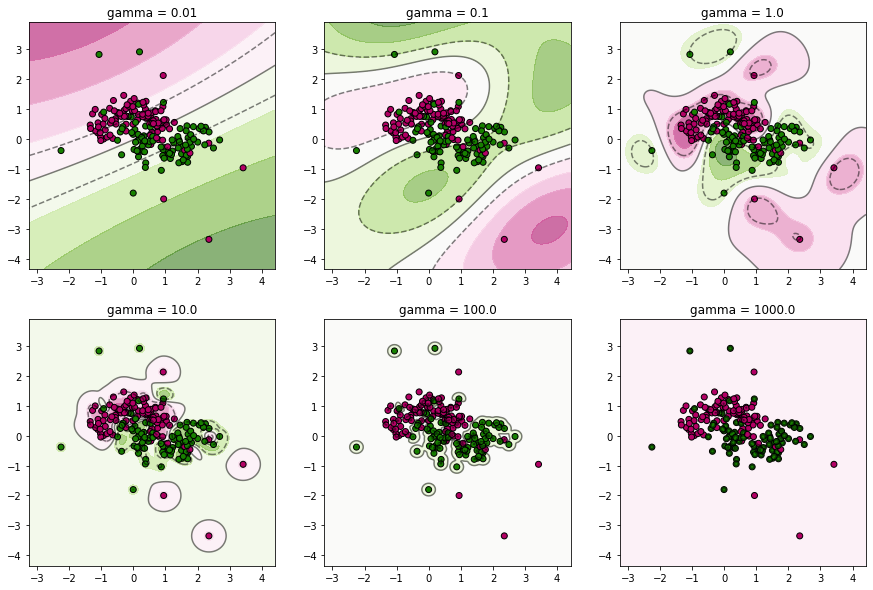

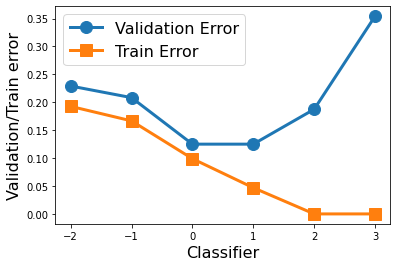

In [5]:
# Learn support vector classifiers with a radial-basis function kernel with 
# fixed C = 10.0 and different values of gamma
import math

gamma_range = np.arange(-2.0, 4.0, 1.0)
gamma_values = np.power(10.0, gamma_range)

models = dict()
trnErr = dict()
valErr = dict()
maxim=math.inf

for G in gamma_values:

  # Insert your code here to learn SVM models
  clf = SVC(C=10,gamma=G)
  clf.fit(X_trn, y_trn)
  models[G]=clf
  trnErr[G]= 1- clf.score(X_trn,y_trn)
  valErr[G]= 1- clf.score(X_val,y_val)
  # print(G,valErr[G])
  if valErr[G] < maxim:
   maxim=valErr[G]
   gbest=G
  
visualize(models, 'gamma', X_trn, y_trn)
# Insert your code here to perform model selection
print("Best value of G:",gbest)
print("Accuracy of test data as per best G:",1- models[gbest].score(X_tst,y_tst))

# Plot all the models
plt.figure()
plt.plot(list(range(-2,4)), list(valErr.values()), marker='o', linewidth=3, markersize=12)
plt.plot(list(range(-2,4)), list(trnErr.values()), marker='s', linewidth=3, markersize=12)
plt.xlabel('Classifier', fontsize=16)
plt.ylabel('Validation/Train error', fontsize=16)
plt.legend(['Validation Error', 'Train Error'], fontsize=16)


The training error decreases with the increase in the value of gamma but the validatioon error first fdecreases and then increases.

---
# 2. <font color='#556b2f'> **Breast Cancer Diagnosis with Support Vector Machines**</font>, 25 points. 

For this problem, we will use the [Wisconsin Breast Cancer](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) data set, which has already been pre-processed and partitioned into training, validation and test sets. Numpy's [loadtxt](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.loadtxt.html) command can be used to load CSV files.

In [0]:
# Load the Breast Cancer Diagnosis data set; download the files from eLearning
# CSV files can be read easily using np.loadtxt()
#
# Insert your code here.
#
import csv
import numpy as np
X_trn_a= np.empty((0))


trn_file='wdbc_trn.csv'
arr= np.loadtxt(trn_file, delimiter=',')
y_trn=arr[:,0]
X_trn=np.delete(arr,0, axis=1)

tst_file='wdbc_tst.csv'
arr2= np.loadtxt(tst_file, delimiter=',')
y_tst=arr2[:,0]
X_tst=np.delete(arr2,0, axis=1)

val_file='wdbc_val.csv'
arr3= np.loadtxt(val_file, delimiter=',')
y_val=arr3[:,0]
X_val=np.delete(arr3,0, axis=1)



Use scikit-learn's [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) function to learn SVM models with **radial-basis kernels** for **each combination** of $C \in \{10^{-2}, 10^{-1}, 1, 10^1, \, \cdots\, 10^4\}$ and $\gamma \in \{10^{-3}, 10^{-2}\, 10^{-1}, 1, \, 10, \, 10^2\}$. Print the tables corresponding to the training and validation errors.

**Final Model Selection**: Use the validation set to select the best the classifier corresponding to the best parameter values, $C_{best}$ and $\gamma_{best}$. Report the accuracy on the **test set** for this selected best SVM model. _Note: You should report a single number, your final test set accuracy on the model corresponding to $C_{best}$ and $\gamma_{best}$_.

In [0]:
# Insert your code here to perform model selection

import math
from sklearn.svm import SVC

C_range = np.arange(-3.0, 6.0, 1.0)
C_values = np.power(10.0, C_range)

gamma_range = np.arange(-2.0, 4.0, 1.0)
gamma_values = np.power(10.0, gamma_range)

maxim=math.inf

for C in C_values:
  models[C] = {}
  trnErr[C] = {}
  valErr[C] = {}
  for G in gamma_values:

    # Insert your code here to learn SVM models
    clf = SVC(C=C, kernel='rbf', gamma=G)
    clf.fit(X_trn, y_trn)
    models[C][G]=clf
    trnErr[C][G]= 1- clf.score(X_trn,y_trn)
    valErr[C][G]= 1- clf.score(X_val,y_val)
    
    if valErr[C][G] < maxim:
      maxim=valErr[C][G]
      gbest=G
      cbest=C

# visualize(models, 'gamma', X_trn, y_trn)
  
def printTable(trnErr):
  print("C, G", end="\t\t\t")
  for gamma in gamma_values:
    print(gamma, end="\t")
  print("")

  for key, val in trnErr.items():
    print(key, end="\t\t\t")
    for key2, val2 in val.items():
      print(round(val2,4), end="\t")
    print("")

print("Training Error Table: ")
printTable(trnErr)
print("\nValidation Error Table:")
printTable(valErr)
  
# Insert your code here to perform model selection
print("Best value of C:",cbest)
print("Best value of G:",gbest)
print("Accuracy of test data as per best G and C:",models[cbest][gbest].score(X_tst,y_tst)*100, "%")



Training Error Table: 
C, G			0.01	0.1	1.0	10.0	100.0	1000.0	
0.001			0.3717	0.3717	0.3717	0.3717	0.3717	0.3717	
0.01			0.3717	0.3717	0.3717	0.3717	0.3717	0.3717	
0.1			0.0501	0.0354	0.3717	0.3717	0.3717	0.3717	
1.0			0.0295	0.0118	0.0	0.0	0.0	0.0	
10.0			0.0118	0.0	0.0	0.0	0.0	0.0	
100.0			0.0029	0.0	0.0	0.0	0.0	0.0	
1000.0			0.0	0.0	0.0	0.0	0.0	0.0	
10000.0			0.0	0.0	0.0	0.0	0.0	0.0	
100000.0			0.0	0.0	0.0	0.0	0.0	0.0	

Validation Error Table:
C, G			0.01	0.1	1.0	10.0	100.0	1000.0	
0.001			0.3739	0.3739	0.3739	0.3739	0.3739	0.3739	
0.01			0.3739	0.3739	0.3739	0.3739	0.3739	0.3739	
0.1			0.0696	0.0783	0.3739	0.3739	0.3739	0.3739	
1.0			0.0609	0.0435	0.3739	0.3739	0.3739	0.3739	
10.0			0.0435	0.0348	0.3739	0.3739	0.3739	0.3739	
100.0			0.0261	0.0348	0.3739	0.3739	0.3739	0.3739	
1000.0			0.0261	0.0348	0.3739	0.3739	0.3739	0.3739	
10000.0			0.0261	0.0348	0.3739	0.3739	0.3739	0.3739	
100000.0			0.0261	0.0348	0.3739	0.3739	0.3739	0.3739	
Best value of C: 100.0
Best value of G: 0.01
Accurac

---
# 3. <font color='#556b2f'> **Breast Cancer Diagnosis with $k$-Nearest Neighbors**</font>, 25 points. 

Use scikit-learn's [k-nearest neighbor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) classifier to learn models for Breast Cancer Diagnosis with $k \in \{1, \, 5, \, 11, \, 15, \, 21\}$, with the kd-tree algorithm.

**Plot**: For each classifier, compute **both** the **training error** and the **validation error**. Plot them together, making sure to label the axes and each curve clearly.

**Final Model Selection**: Use the validation set to select the best the classifier corresponding to the best parameter value, $k_{best}$. Report the accuracy on the **test set** for this selected best kNN model. _Note: You should report a single number, your final test set accuracy on the model corresponding to $k_{best}$_.

The best value of K is: 5
Accuracy of test data as per best K: 95.65217391304348 %


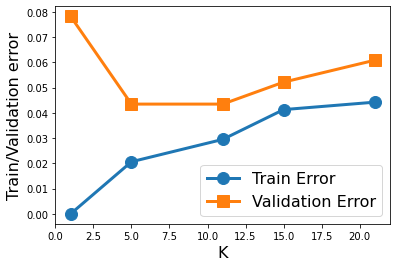

In [7]:
#
#
# Insert your code here to perform model selection
from sklearn.neighbors import KNeighborsClassifier
models = dict()
trnErr = dict()
valErr = dict()
maxim=math.inf
kbest = 0
k = np.array([1,5,11,15,21])

for m in k:
  neigh = KNeighborsClassifier(n_neighbors=m,algorithm = 'kd_tree')
  neigh.fit(X_trn, y_trn)
  models[m] = neigh
  trnErr[m] = 1 - neigh.score(X_trn,y_trn)
  valErr[m] = 1 - neigh.score(X_val,y_val)
  if valErr[m]<maxim:
    maxim = valErr[m]
    kbest = m

print("The best value of K is:",kbest)

# Plot all the models
plt.figure()
plt.plot(list(trnErr.keys()), list(trnErr.values()), marker='o', linewidth=3, markersize=12)
plt.plot(list(trnErr.keys()), list(valErr.values()), marker='s', linewidth=3, markersize=12)
plt.xlabel('K', fontsize=16)
plt.ylabel('Train/Validation error', fontsize=16)
plt.legend(['Train Error', 'Validation Error'], fontsize=16)

acc = models[kbest].score(X_tst,y_tst)
print("Accuracy of test data as per best K:", acc*100,"%")

**Discussion**: Which of these two approaches, SVMs or kNN, would you prefer for this classification task? Explain.

As we can see above that the accuracy for SVM is 96.52173913043478 % and kNN is 95.65217391304348 %.
I would prefer SVM as the accuracy under SVM is more.
Also kNN is preferable if the number of columns/attributes in the data given is less than 15 but in our dataset the number of attributes is 30.
SVM is Memory-intensive as it requires a lot of time for training if the training set is huge but the dataset given to us is not large.

Thus to sum up I would prefer SVM over kNN as per the dataset given.